<a href="https://colab.research.google.com/github/dhnanjay/HuggingFace/blob/main/SAWYER_LLAMA2_SFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
!pip install transformers[torch] datasets wandb peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━

# Imports

In [ ]:
import numpy as np
import os
import torch
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    logging,
    DataCollatorForLanguageModeling
)
import json
import pandas as pd
from peft import LoraConfig, PeftModel, get_peft_model

# Setup

In [ ]:
import os
from google.colab import userdata

os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
from datasets import load_dataset

assistant_dataset = load_dataset("timdettmers/openassistant-guanaco")

original_guanaco_dataset = load_dataset("guanaco/guanaco")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
assistant_dataset['train'][0]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

In [ ]:
original_guanaco_dataset['train'][0]

{'response': "The man is quite tall with a slender physique. His dark hair is styled in a sleek, classic pompadour with a slight sheen to it, suggesting perhaps he spends time grooming it. The hair appears to be well-maintained, as though he's put some effort into it. The dark color of his hair contrasts with his pale skin, which gives him a somewhat striking appearance. He conveys a sense of poise and confidence, as though he's comfortable in his own skin. Overall, he seems to exude a sophisticated, polished vibe.",
 'text': "Describe the following:\nA tall, thin man with dark hair styled in a slick pompadour.### Response:\nThe man is quite tall with a slender physique. His dark hair is styled in a sleek, classic pompadour with a slight sheen to it, suggesting perhaps he spends time grooming it. The hair appears to be well-maintained, as though he's put some effort into it. The dark color of his hair contrasts with his pale skin, which gives him a somewhat striking appearance. He conv

# Parse Conversations

In [ ]:
# Function to parse the JSON and extract human/bot conversations
def parse_conversations(json_data):
    if 'prompt' in json_data and 'response' in json_data:
        return [['human', json_data['prompt']], ['assistant', json_data['response']]]
    # Split the text on '###' to separate conversations
    conversations = json_data['text'].split('###')

    # Process each conversation and split into human and bot parts
    convos = []
    for convo in conversations:
        if convo.strip():  # Check if the string is not just whitespace
            parts = convo.strip().split(': ', 1)  # Split on the first occurrence of ': '
            if len(parts) == 2:
                speaker, message = parts
                convos.append((speaker.lower(), message))

    return convos

# Parse the conversations
print(parse_conversations(assistant_dataset['train'][0]))
print(parse_conversations(original_guanaco_dataset['train'][0]))

[('human', 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'), ('assistant', '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, 

In [ ]:
assistant_dataset = assistant_dataset.map(lambda x: {'conversation': parse_conversations(x)})
assistant_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'conversation'],
        num_rows: 9846
    })
    test: Dataset({
        features: ['text', 'conversation'],
        num_rows: 518
    })
})

In [ ]:
original_guanaco_dataset = original_guanaco_dataset.map(lambda x: {'conversation': parse_conversations(x)})
original_guanaco_dataset

DatasetDict({
    train: Dataset({
        features: ['response', 'text', 'prompt', 'conversation'],
        num_rows: 48701
    })
})

In [ ]:
dataset = Dataset.from_dict({'conversation': list(assistant_dataset['train']['conversation']) + list(original_guanaco_dataset['train']['conversation'])})
dataset = dataset.train_test_split(test_size=0.2, seed=42)

dataset

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 46837
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 11710
    })
})

In [ ]:
STOP_TOKEN = '###STOP###'  # we are making these up
HUMAN_TOKEN = '###HUMAN###'
BOT_TOKEN = '###BOT###'

EXTRA_TOKENS = {
    'stop_token': {
        'token': STOP_TOKEN,
        'replace_embedding_with': 'stop talking'
    },
    'human_token': {
        'token': HUMAN_TOKEN,
        'replace_embedding_with': 'The human said:'
    },
    'bot_token': {
        'token': BOT_TOKEN,
        'replace_embedding_with': 'The assistant said:'
    }
}

# Model from Hugging Face hub. I'm using the non chat format to show that you don't need to start from the chat checkpoint
base_model = "NousResearch/Llama-2-7b-hf"


# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

tokenizer.add_tokens([extra['token'] for extra in EXTRA_TOKENS.values()])

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

3

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=quant_config,
    device_map={"": 0}
)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
print(model.config.vocab_size)
model.resize_token_embeddings(len(tokenizer))
print(model.config.vocab_size)

32000
32003


In [ ]:
for extra_token, extra_info in EXTRA_TOKENS.items():
    token_id = tokenizer(extra_info['token'])['input_ids'][-1]
    new_embedding = model.model.embed_tokens.weight.data[tokenizer(extra_info['replace_embedding_with'])['input_ids'][1:]].mean(dim=0, keepdim=True)#.reshape(-1)
    EXTRA_TOKENS[extra_token]['new_embedding'] = new_embedding
    model.model.embed_tokens.weight.data[token_id] = EXTRA_TOKENS[extra_token]['new_embedding'].clone()
    EXTRA_TOKENS[extra_token]['token_id'] = token_id
    print(f"Replaced token \"{extra_info['token']}\" (token id {token_id}) weight with weight for \"{extra_info['replace_embedding_with']}\"")

Replaced token "###STOP###" (token id 32000) weight with weight for "stop talking"
Replaced token "###HUMAN###" (token id 32001) weight with weight for "The human said:"
Replaced token "###BOT###" (token id 32002) weight with weight for "The assistant said:"


In [ ]:
EXTRA_TOKENS

{'stop_token': {'token': '###STOP###',
  'replace_embedding_with': 'stop talking',
  'new_embedding': tensor([[-0.0161,  0.0000, -0.0031,  ...,  0.0137, -0.0084, -0.0071]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 32000},
 'human_token': {'token': '###HUMAN###',
  'replace_embedding_with': 'The human said:',
  'new_embedding': tensor([[-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 32001},
 'bot_token': {'token': '###BOT###',
  'replace_embedding_with': 'The assistant said:',
  'new_embedding': tensor([[0.0009, 0.0023, 0.0064,  ..., 0.0030, 0.0111, 0.0021]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 32002}}

In [ ]:
dataset['train'][0]

{'conversation': [['human', 'Cuéntame un chiste sobre un tomate y algo más'],
  ['assistant',
   'Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO!']]}

In [ ]:
text_pd = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['test'])])

text_pd['split'] = ['train'] * len(dataset['train']) + ['test'] * len(dataset['test'])

text_pd['convo_length'] = text_pd['conversation'].apply(len)
text_pd['last_speaker'] = text_pd['conversation'].apply(lambda x: x[-1][0])

In [ ]:
text_pd = text_pd[text_pd['last_speaker'].isin(['assistant', 'human'])]
text_pd['last_speaker'].value_counts()

assistant    56066
human         2471
Name: last_speaker, dtype: int64

In [ ]:
text_pd.head(2)

,conversation,split,convo_length,last_speaker
0,"[[human, Cuéntame un chiste sobre un tomate y ...",train,2,assistant
1,"[[human, Write a letter recommending someone f...",train,2,assistant


In [ ]:
text_pd = text_pd[text_pd['last_speaker'] == 'assistant']
text_pd = text_pd[text_pd['convo_length'] % 2 == 0]

text_pd = text_pd.reset_index()

<Axes: >

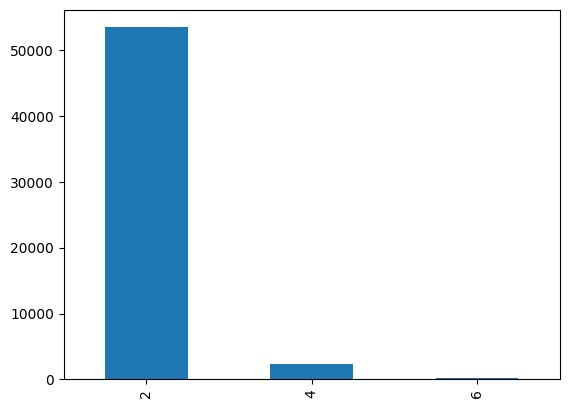

In [ ]:
text_pd['convo_length'].value_counts().sort_index().plot.bar()

In [ ]:
text_pd['first_question'] = text_pd['conversation'].apply(lambda x: x[0][1])
text_pd['first_question'].value_counts()

你好                                                                                                                             10
Write a short story about a haunted house.                                                                                      4
Generate five adjectives to describe a sunset.                                                                                  4
Write a poem about the ocean.                                                                                                   4
Hello                                                                                                                           4
                                                                                                                               ..
Write a letter of recommendation for a former coworker or employee.                                                             1
Generate a paragraph on the topic of gun control laws.                                    

# Filter out by language

In [ ]:
FILTER_EN = False

In [ ]:
filtered_dataset = dataset.filter(lambda x: len(x['conversation'][0][1]) < 10)
filtered_dataset

Filter:   0%|          | 0/46837 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11710 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['conversation'],
        num_rows: 137
    })
    test: Dataset({
        features: ['conversation'],
        num_rows: 36
    })
})

In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Define a function for batch processing
def detect_language_in_batches(batch, batch_size=128):
    batch_results = pipe([b[0][1] for b in batch['conversation']])
    return {'lang': [b['label'] for b in batch_results]}

# Apply the function to the DataFrame
if FILTER_EN:
    pipe = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection", truncation=True, max_length=64)
    dataset = dataset.map(detect_language_in_batches, batch_size=128, batched=True)

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

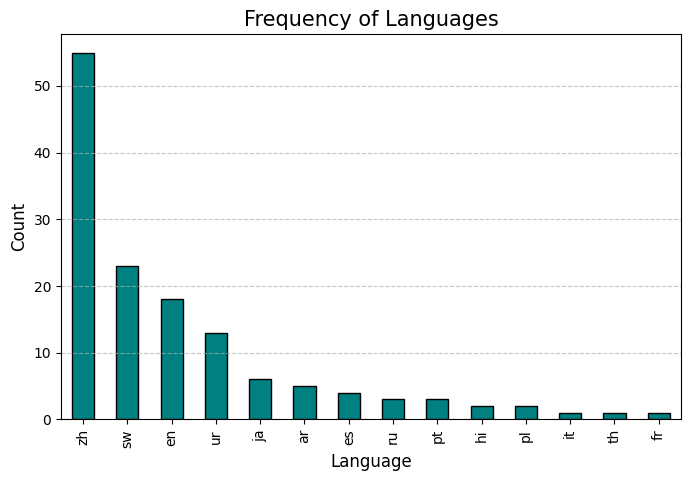

In [ ]:
if FILTER_EN:
    import matplotlib.pyplot as plt

    # Filtering for English language

    # Counting the occurrences of each language
    lang_counts = pd.Series(filtered_dataset['train']['lang']).value_counts()

    # Creating the bar plot
    plt.figure(figsize=(8, 5))
    lang_counts.plot.bar(color='teal', edgecolor='black')

    # Adding titles and labels
    plt.title('Frequency of Languages', fontsize=15)
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Adding grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Displaying the plot
    plt.show()


In [ ]:
if FILTER_EN:
    dataset = dataset.filter(lambda x: x['lang'] == 'en')

In [ ]:
def join_convo(conversation):
    convo = ''''''
    last_speaker = None
    for speaker, message in conversation:
        last_speaker = speaker
        if speaker == 'human':
            convo += f"{EXTRA_TOKENS['human_token']['token']} {message} "
        elif speaker == 'assistant':
            convo += f"{EXTRA_TOKENS['bot_token']['token']} {message} "
    if last_speaker == 'human':
        return convo.strip() + f" {EXTRA_TOKENS['bot_token']['token']}"
    return convo.strip() + f" {EXTRA_TOKENS['stop_token']['token']}"

text_pd['text'] = text_pd['conversation'].apply(join_convo)

In [ ]:
dataset['train'][0]['conversation']

[['human', 'Cuéntame un chiste sobre un tomate y algo más'],
 ['assistant',
  'Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO!']]

In [ ]:
model.generation_config.do_sample = True
model.config.use_cache = False
# "Setting pretraining_tp to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits."
model.config.pretraining_tp = 1

In [ ]:
print(join_convo([['human', "Who was the first president of the USA?"]]))

###HUMAN### Who was the first president of the USA? ###BOT###


In [ ]:
# Load LoRA configuration to make training much more efficient
peft_args = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.05,
    r=128,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_args)

In [ ]:
model.print_trainable_parameters()

trainable params: 67,108,864 || all params: 6,805,549,056 || trainable%: 0.9860903719566105


# Before

In [ ]:
tokenizer.decode(
    model.generate(
        **tokenizer(join_convo([['human', "Who was the first president of the USA?"]]), return_tensors='pt'),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


'<s>###HUMAN### Who was the first president of the USA?###BOT###,###HUMAN###,###HUMAN###, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes'

In [ ]:
dataset = dataset.map(lambda x: {'text': join_convo(x['conversation'])})

dataset['train'][0]

Map:   0%|          | 0/46837 [00:00<?, ? examples/s]

Map:   0%|          | 0/11710 [00:00<?, ? examples/s]

{'conversation': [['human', 'Cuéntame un chiste sobre un tomate y algo más'],
  ['assistant',
   'Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO!']],
 'text': '###HUMAN### Cuéntame un chiste sobre un tomate y algo más ###BOT### Esto es un tomate que está haciendo el ridículo y otro tomate le grita: TE ESTÁS PONIENDO COMO UN HUMANO! ###STOP###'}

In [ ]:
dataset = dataset.map(lambda x: tokenizer(x['text']))

Map:   0%|          | 0/46837 [00:00<?, ? examples/s]

Map:   0%|          | 0/11710 [00:00<?, ? examples/s]

In [ ]:
# zero out loss before the final response token

class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):

    def torch_call(self, examples):
        self.tokenizer.pad(examples, return_tensors="pt", pad_to_multiple_of=self.pad_to_multiple_of)
        batch = super().torch_call(examples)
        response_token_id = EXTRA_TOKENS['bot_token']['token_id']

        labels = batch["input_ids"].clone()
        for i in range(len(examples)):
            tokens = batch["input_ids"].clone().tolist()[i]
            if tokens.count(response_token_id) == 0:
                print(tokens)
            up_until = len(tokens) - 1 - tokens[::-1].index(response_token_id)
            labels[i, :up_until + 1] = -100


        batch["labels"] = labels

        return batch

data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer, mlm=False, return_tensors="pt"
)

In [ ]:
batch = data_collator(
    [
        dataset.select_columns(['input_ids', 'attention_mask'])['train'][0],
        dataset.select_columns(['input_ids', 'attention_mask'])['train'][1]
    ]
)
print(batch['input_ids'])
print(batch['labels'])

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,  

In [ ]:
# get batch['labels'] that aren't -100
tokenizer.decode(batch['labels'][1][batch['labels'][1] != -100])

'Dear Hiring Manager,\n\nI am writing to highly recommend [Name] for [Job position]. I have had the pleasure of working closely with [Name] for [duration] at [company/organization], and have witnessed their exceptional work ethic, exceptional skill set, and infectious positive attitude.\n\nDuring our time together, I have observed [Name] consistently go above and beyond what is expected, delivering quality work while maintaining a high level of professionalism. [He/She] possesses strong problem-solving skills and is able to think on [his/her] feet, adapting quickly to changes in the workplace. [Name] is also extremely organized, detail-oriented, and has a keen eye for identifying and solving inefficiencies to streamline processes and improve productivity.\n\nMoreover, [Name] is an excellent communicator and team player who fosters a positive work environment. [He/She] takes the initiative to share knowledge and expertise with others and is always willing to lend a helping hand to teamm

<Axes: >

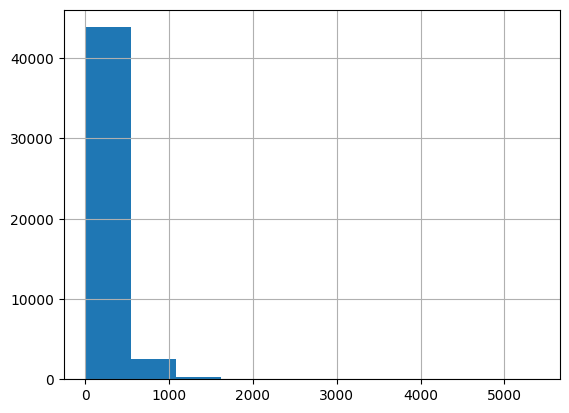

In [ ]:
pd.Series([len(x) for x in dataset['train']['input_ids']]).hist()

In [ ]:
# remove elements that are too long for the LLM
dataset = dataset.filter(
    # lambda x: len(x['input_ids']) < model.config.max_position_embeddings
    lambda x: len(x['input_ids']) < 1024  # truncating a lot for memory
    )
dataset

Filter:   0%|          | 0/46837 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11710 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['conversation', 'text', 'input_ids', 'attention_mask'],
        num_rows: 46330
    })
    test: Dataset({
        features: ['conversation', 'text', 'input_ids', 'attention_mask'],
        num_rows: 11596
    })
})

<Axes: >

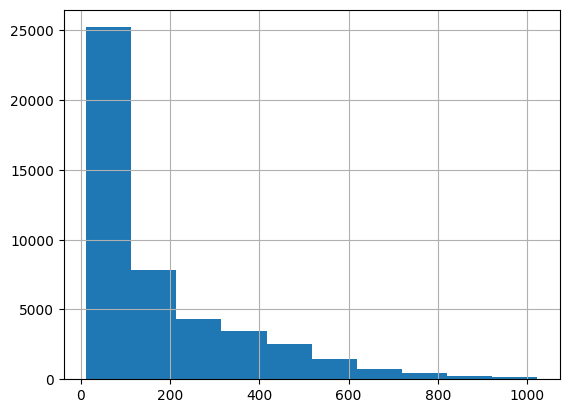

In [ ]:
pd.Series([len(x) for x in dataset['train']['input_ids']]).hist()

In [ ]:
!huggingface-cli whoami

profoz


In [ ]:
# Set supervised fine-tuning parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    logging_steps=5,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=False,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    bf16=False,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",

    push_to_hub=True,
    hub_model_id="profoz/sawyer-llama-2",
    hub_strategy="every_save",
)
trainer = Trainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    args=training_params,
    data_collator=data_collator
)

In [ ]:
trainer.hub_model_id

'profoz/sawyer-llama-2'

In [ ]:
model.base_model.model.model.embed_tokens.weight.data

tensor([[ 1.2517e-06, -1.7881e-06, -4.3511e-06,  ...,  8.9407e-07,
         -6.5565e-06,  8.9407e-07],
        [ 1.8616e-03, -3.3722e-03,  3.9864e-04,  ..., -8.3008e-03,
          2.5787e-03, -3.9368e-03],
        [ 1.0986e-02,  9.8877e-03, -5.0964e-03,  ...,  2.5177e-03,
          7.7057e-04, -5.0049e-03],
        ...,
        [-1.6113e-02,  0.0000e+00, -3.1281e-03,  ...,  1.3672e-02,
         -8.3618e-03, -7.0801e-03],
        [-4.6387e-03, -2.8381e-03,  1.5747e-02,  ..., -3.0060e-03,
          6.6223e-03,  4.6997e-03],
        [ 9.2697e-04,  2.3499e-03,  6.3782e-03,  ...,  2.9907e-03,
          1.1108e-02,  2.0905e-03]], device='cuda:0', dtype=torch.bfloat16)

In [ ]:
trainer.evaluate()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': nan,
 'eval_runtime': 1275.2969,
 'eval_samples_per_second': 9.093,
 'eval_steps_per_second': 9.093}

In [ ]:
# Train model (I meant to do one epoch here and stopped it)
trainer.train()

Epoch,Training Loss,Validation Loss
0,1.114800,nan


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:160: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
model.base_model.model.model.embed_tokens.weight.data

tensor([[ 1.2517e-06, -1.7881e-06, -4.3511e-06,  ...,  8.9407e-07,
         -6.5565e-06,  8.9407e-07],
        [ 1.8616e-03, -3.3722e-03,  3.9864e-04,  ..., -8.3008e-03,
          2.5787e-03, -3.9368e-03],
        [ 1.0986e-02,  9.8877e-03, -5.0964e-03,  ...,  2.5177e-03,
          7.7057e-04, -5.0049e-03],
        ...,
        [-1.6113e-02,  0.0000e+00, -3.1281e-03,  ...,  1.3672e-02,
         -8.3618e-03, -7.0801e-03],
        [-4.6387e-03, -2.8381e-03,  1.5747e-02,  ..., -3.0060e-03,
          6.6223e-03,  4.6997e-03],
        [ 9.2697e-04,  2.3499e-03,  6.3782e-03,  ...,  2.9907e-03,
          1.1108e-02,  2.0905e-03]], device='cuda:0', dtype=torch.bfloat16)

In [ ]:
trainer.evaluate()

In [ ]:
# Save trained model locally

# Fine-tuned model name
new_model = "llama-2-7b-chat-ft"

trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:160: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


# After

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
tokenizer.decode(
    trainer.model.generate(
        **tokenizer(join_convo([['human', "Who was the first president of the USA?"]]), return_tensors='pt').to(0),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

'<s>###HUMAN### Who was the first president of the USA?###BOT### George Washington.###STOP###'

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
tokenizer.decode(
    trainer.model.generate(
        **tokenizer(join_convo([['human', "hello"]]), return_tensors='pt').to(0),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

'<s>###HUMAN### hello###BOT### Hello! How can I help you today?###STOP###'

In [ ]:
for e, d in EXTRA_TOKENS.items():
    print(d['new_embedding'].detach().cpu().tolist())

[[-0.01611328125, 0.0, -0.0031280517578125, 0.003631591796875, -0.02783203125, 0.0084228515625, -0.0013275146484375, 0.01904296875, 0.0128173828125, -0.0152587890625, -0.00994873046875, 0.01263427734375, 0.0162353515625, 0.005828857421875, 0.005096435546875, 0.0086669921875, -0.01190185546875, 0.002227783203125, 0.007354736328125, -0.00396728515625, 0.00335693359375, 0.006011962890625, 0.0244140625, -0.0031890869140625, -0.001861572265625, -0.0081787109375, -0.0096435546875, -0.010009765625, -0.00103759765625, -0.00148773193359375, 0.032470703125, 0.005401611328125, -0.002288818359375, -8.392333984375e-05, -0.003204345703125, -0.0107421875, 0.004638671875, -0.00421142578125, 0.00799560546875, -0.0003662109375, 0.0037078857421875, 0.00732421875, -0.00848388671875, -0.010498046875, 0.00579833984375, -0.000457763671875, 0.01080322265625, -0.002410888671875, -0.017578125, 0.015625, -0.002532958984375, 0.017578125, -0.01275634765625, -0.000885009765625, -0.01129150390625, -0.0135498046875, 

In [ ]:
trainer.push_to_hub()

adapter_model.safetensors:   0%|          | 0.00/793M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1707587399.9c0684bcaa91.1292.0:   0%|          | 0.00/375k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/profoz/sawyer-llama-2/commit/0ff6162ddb5d2c67c00b23ea60b810c20a6630fd', commit_message='End of training', commit_description='', oid='0ff6162ddb5d2c67c00b23ea60b810c20a6630fd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub('profoz/sawyer-llama-2')

CommitInfo(commit_url='https://huggingface.co/profoz/sawyer-llama-2/commit/32003634796cae5ce31e7c7ed74d7edbb4f80c23', commit_message='Upload tokenizer', commit_description='', oid='32003634796cae5ce31e7c7ed74d7edbb4f80c23', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Reload model and merge it with LoRA weights
base_model = 'NousResearch/Llama-2-7b-hf'

hf_load_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.bfloat16,
    device_map={"": 0},
)
hf_load_model.resize_token_embeddings(len(tokenizer))

hf_load_model = PeftModel.from_pretrained(hf_load_model, 'profoz/sawyer-llama-2')

hf_load_model = hf_load_model.merge_and_unload()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/603 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/793M [00:00<?, ?B/s]

In [ ]:
EXTRA_TOKENS

{'stop_token': {'token': '###STOP###',
  'replace_embedding_with': 'stop talking',
  'new_embedding': tensor([[-0.0161,  0.0000, -0.0031,  ...,  0.0137, -0.0084, -0.0071]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 32000},
 'human_token': {'token': '###HUMAN###',
  'replace_embedding_with': 'The human said:',
  'new_embedding': tensor([[-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 32001},
 'bot_token': {'token': '###BOT###',
  'replace_embedding_with': 'The assistant said:',
  'new_embedding': tensor([[0.0009, 0.0023, 0.0064,  ..., 0.0030, 0.0111, 0.0021]],
         device='cuda:0', dtype=torch.bfloat16),
  'token_id': 32002}}

In [ ]:
model.model.model.embed_tokens.weight.data == hf_load_model.model.embed_tokens.weight.data

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
model.model.model.embed_tokens.weight.data[32001]

tensor([-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
hf_load_model.model.embed_tokens.weight.data[32001]

tensor([-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
for extra_token, token_info in EXTRA_TOKENS.items():
    print(token_info['token_id'], token_info['new_embedding'].clone().to(torch.bfloat16)[:5])
    hf_load_model.model.embed_tokens.weight.data[token_info['token_id']] = token_info['new_embedding'].clone().to(torch.bfloat16)

32000 tensor([[-0.0161,  0.0000, -0.0031,  ...,  0.0137, -0.0084, -0.0071]],
       device='cuda:0', dtype=torch.bfloat16)
32001 tensor([[-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047]],
       device='cuda:0', dtype=torch.bfloat16)
32002 tensor([[0.0009, 0.0023, 0.0064,  ..., 0.0030, 0.0111, 0.0021]],
       device='cuda:0', dtype=torch.bfloat16)


In [ ]:
hf_load_model.model.embed_tokens.weight.data[32001]

tensor([-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
hf_load_model.model.embed_tokens.weight.data[32001]

tensor([-0.0046, -0.0028,  0.0157,  ..., -0.0030,  0.0066,  0.0047],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
model.model.model.embed_tokens.weight.data == hf_load_model.model.embed_tokens.weight.data

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
tokenizer.decode(
    hf_load_model.generate(
        **tokenizer(join_convo([['human', "Who was the first president of the USA?"]]), return_tensors='pt').to(0),
        max_length=64,
        eos_token_id=EXTRA_TOKENS['stop_token']['token_id']
        )[0]
    )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


'<s>###HUMAN### Who was the first president of the USA?###BOT### George Washington.###STOP###'

In [ ]:
def generate_text(conversation, model, **kwargs):
    prompt = join_convo(conversation)
    return tokenizer.decode(
        model.generate(
            **tokenizer(prompt, return_tensors='pt').to(model.device),
            max_length=128,
            eos_token_id=EXTRA_TOKENS['stop_token']['token_id'],
            **kwargs
            )[0],
        skip_special_tokens=True,
        )

In [ ]:
# the model we just trained (not the one we are about to de-serialize)
print(generate_text(
    [['human', "Who was the first president of the USA?"]],
    model
))

###HUMAN### Who was the first president of the USA?###BOT### George Washington.###STOP###


In [ ]:
# we want this to be about the same.
print(generate_text(
    [['human', "Who was the first president of the USA?"]],
    hf_load_model
))

###HUMAN### Who was the first president of the USA?###BOT### George Washington.###STOP###


In [ ]:
# we want this to be about the same.
print(generate_text(
    [['human', "Hey there"]],
    hf_load_model
))

###HUMAN### Hey there###BOT### Hello! How can I help you today?###STOP###
